Analysis code from PyPSA-BO

https://github.com/CIE-UMSS/PyPSA-BO/blob/main/Results_analysis/EnergyScope-PyPSA/general_analysis.ipynb

In [2]:
#Libraries import for running the code

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt
import cartopy

# data exploration
import xarray as xr

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)



max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

#Load different networks

base_network= "C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/base.nc"
n_base= pypsa.Network(base_network) #network with all components available in the data sources 

added_network = "C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/elec.nc"
n_add = pypsa.Network(added_network) #output from add_electricity. network with electrical parameters added to components in data sources 

simplified_network = "C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/elec_s.nc"
n_simple = pypsa.Network(simplified_network) #output simplyfy_network with components simplified and spatial parameters (onshore and offshore regions) added  

clustered_network = 'C:/Users/hie/pe_tan/pypsa-earth/networks/2040_base/elec_s_all.nc'
n_cluster = pypsa.Network(clustered_network) #output clustering-network simplified based on number of clusters give

solved_network = r'C:\Users\hie\pe_tan\pypsa-earth\results\2040_base\networks\elec_s_all_ec_lcopt_1h.nc'
n_solve = pypsa.Network(solved_network) #optimized network

n = n_solve

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers
INFO:pypsa.io:Imported network elec_s.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_all.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, loads, storage_units


In [3]:
# System cost in Million EUR/Year

system_cost_million_eur = n.objective / 1e6  # Convert to million EUR/year

# Print the result
print(f"System cost: {system_cost_million_eur:.2f} Million EUR/Year")

System cost: 29768312.37 Million EUR/Year


In [4]:
#check lines

n_solve.lines.capital_cost.sum()


377807.22776719194

In [5]:
n_add.lines.capital_cost.sum()

471386.27373676427

In [6]:
line_expansion_cost = n.lines.capital_cost.sum()-n_simple.lines.capital_cost.sum() # difference between the two networks (Eur/MW)
print("Capital cost for line expansion: " + str(line_expansion_cost/1000000) + " Million Eur")

Capital cost for line expansion: -0.09357904596957232 Million Eur


In [7]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap.p_nom


carrier
CCGT          1.192700e+03
OCGT          1.850000e+02
coal          6.000000e+02
geothermal    1.350000e+02
load          6.700000e+10
onwind        9.110670e-01
ror           6.017862e+02
solar         1.447219e+01
Name: p_nom, dtype: float64

In [8]:
#optimized

gen_cap.p_nom_opt

carrier
CCGT          5.025265e+03
OCGT          1.850000e+02
coal          6.020860e+02
geothermal    9.950000e+02
load          6.700000e+10
onwind        1.370000e+03
ror           6.017862e+02
solar         3.000000e+03
Name: p_nom_opt, dtype: float64

In [9]:
stores_cap = n.storage_units.groupby(["carrier"]).sum()
stores_cap.p_nom_opt

carrier
hydro    4340.625972
Name: p_nom_opt, dtype: float64

In [10]:
#installed capacity expansion
generation_expansion = gen_cap['p_nom_opt'] - gen_cap['p_nom']
generation_expansion

carrier
CCGT          3832.564664
OCGT             0.000000
coal             2.086017
geothermal     860.000000
load             0.000000
onwind        1369.088950
ror              0.000000
solar         2985.527825
dtype: float64

In [11]:
generation_expansion.sum()

9049.267456536254

Transmission expansion

In [12]:

n_line = pypsa.Network(base_network)
check_lines = n_line.lines
check_lines.s_nom.mean()

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers


476.32203916739434

In [13]:
lines=n.lines
n.lines.s_nom.mean()

476.32203916739434

In [14]:
#transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']
transmission_expansion

Line
0      584.148567
1      131.522046
2      455.805410
3        0.009841
4      589.039765
         ...     
68     369.272564
69      12.484638
70     232.020190
71    1153.272414
72     456.596709
Length: 73, dtype: float64

In [15]:
# Calculate transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']

# Filter for negative values
negative_expansion = transmission_expansion[transmission_expansion < 0]

# Print the negative values
print("Negative transmission expansions:")
print(negative_expansion)

# Count the number of negative values
print(f"Number of negative expansions: {len(negative_expansion)}")

# Sum of negative expansions
print(f"Total negative expansion (MW): {negative_expansion.sum()}")

Negative transmission expansions:
Series([], dtype: float64)
Number of negative expansions: 0
Total negative expansion (MW): 0.0


In [16]:
n.iplot(mapbox="osm")

{'data': [Scattermapbox({
      'lat': [-6.7116, -6.6413],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [38.7439, 38.3689],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-5.3126, -4.0717],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [38.6298, 37.7377],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-4.8396, -3.6219],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [34.7573, 33.5148],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-8.8482, -8.9146],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [34.8061, 33.4967],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-3.6219, -3.2208],
      'line': {'color': 'rosybrown', 'width': 3},
      'lon': [33.5148, 32.4905],
      'mode': 'lines',
      'opacity': 0.8
  }),
  Scattermapbox({
      'lat': [-3.861, -3.6219],
      'line': {'color'

In [17]:
real_expansion = 0
for i in range(len(transmission_expansion)):  # Iterate over the indices of the Series
    if transmission_expansion.iloc[i] > 0:  # Check if the expansion value is greater than 0
        real_expansion += transmission_expansion.iloc[i]  # Add the expansion value to real_expansion

print("Total expansion of the system:", real_expansion)

Total expansion of the system: 26827.899111737348


In [18]:
max_line_expansion = transmission_expansion.max()
max_line_expansion

1220.7108591325812

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

c:\Users\hie\AppData\Local\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\2452526199.py:165: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



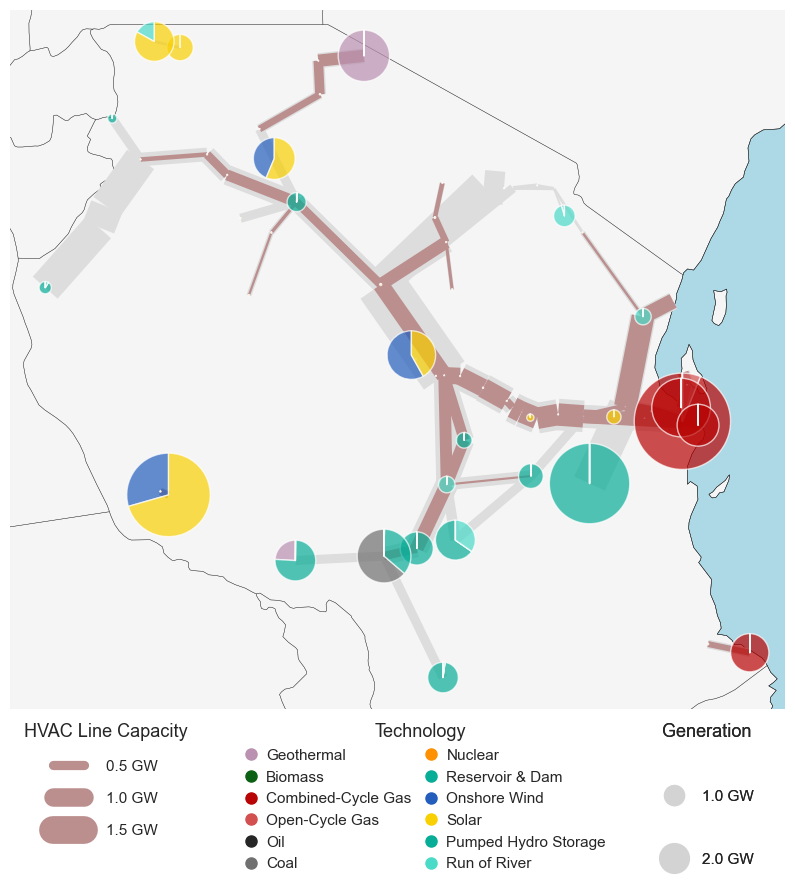

In [19]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.5, 1.0, 1.5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=1.2,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")

    # Filter n.carriers to only exclude "H2" and "batteries"
    filtered_carriers = n.carriers.loc[~n.carriers.index.isin(['H2', 'battery'])]

    # Iterate over the filtered carriers
    for name, carrier in filtered_carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )

        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [10, 20]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=3.2,
        title="Generation",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 6.0e3
    branch_factor = 7.5e1

    fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=100):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = n.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    



    add_legend(ax, bus_factor, branch_factor)

    


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(n)

In [20]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Coal                    6.020860e+02        6.000000e+02   
            Combined-Cycle Gas      5.025265e+03        1.192700e+03   
            Geothermal              9.950000e+02        1.350000e+02   
            Onshore Wind            1.370000e+03        9.110670e-01   
            Open-Cycle Gas          1.850000e+02        1.850000e+02   
            Run of River            6.017862e+02        6.017862e+02   
            Solar                   3.000000e+03        1.447219e+01   
            load                    6.700000e+10        6.700000e+10   
Line        AC                      6.159941e+04        3.477151e+04   
Load        -                       0.000000e+00        0.000000e+00   
StorageUnit Reservoir & Dam         4.340626e+03        4.340626e+03   

                                      Supply    Withdrawal      Dispatch  \
Generator   Coal                5.269048e+06  0.000000e+00  5.269048e+06   
            Combined-Cycle Gas  3.549498e+07  0.000000e+00  3.549498e+07   
            Geothermal          8.707822e+06  0.000000e+00  8.707822e+06   
            Onshore Wind        9.130155e+05  0.000000e+00  9.130155e+05   
            Open-Cycle Gas      4.066085e+05  0.000000e+00  4.066085e+05   
            Run of River        2.920437e+06  0.000000e+00  2.920437e+06   
            Solar               3.118284e+06  0.000000e+00  3.118284e+06   
            load                3.720686e+06  0.000000e+00  3.720686e+06   
Line        AC                  2.596753e+08  2.596753e+08  0.000000e+00   
Load        -                   0.000000e+00  7.885000e+07 -7.885000e+07   
StorageUnit Reservoir & Dam     1.829911e+07  0.000000e+00  1.829911e+07   

                                Transmission  Capacity Factor   Curtailment  \
Generator   Coal                0.000000e+00         0.999009  0.000000e+00   
            Combined-Cycle Gas  0.000000e+00         0.806314  0.000000e+00   
            Geothermal          0.000000e+00         0.999039  0.000000e+00   
            Onshore Wind        0.000000e+00         0.076077  2.341991e+05   
            Open-Cycle Gas      0.000000e+00         0.250900  0.000000e+00   
            Run of River        0.000000e+00         0.553989  6.475558e+04   
            Solar               0.000000e+00         0.118656  1.259542e+06   
            load                0.000000e+00         0.000006  0.000000e+00   
Line        AC                  6.252681e+06         0.481227  0.000000e+00   
Load        -                   0.000000e+00              NaN  0.000000e+00   
StorageUnit Reservoir & Dam     0.000000e+00         0.481253  0.000000e+00   

                                Capital Expenditure  Operational Expenditure  \
Generator   Coal                       2.658205e+08             1.697815e+08   
            Combined-Cycle Gas         6.340972e+08             1.661625e+09   
            Geothermal                 0.000000e+00             8.239555e+04   
            Onshore Wind               1.775253e+08             2.227277e+04   
            Open-Cycle Gas             1.090340e+07             2.630498e+07   
            Run of River               2.465120e+08             3.005263e+04   
            Solar                      1.448679e+08             6.069149e+04   
            load                       0.000000e+00             2.976552e+13   
Line        AC                         3.417679e+08             0.000000e+00   
Load        -                          0.000000e+00             0.000000e+00   
StorageUnit Reservoir & Dam            0.000000e+00             1.777125e+05   

                                     Revenue  Market Value  
Generator   Coal                3.255892e+08  6.179280e+01  
            Combined-Cycle Gas  2.295340e+09  6.466659e+01  
            Geothermal          5.642493e+08  6.479799e+01  
            Onshore Wind        4.558139e+12  4.992400e+06  
            Open-Cycle Gas      4.18352

In [21]:
n.statistics.dispatch().sum()

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3758984340.py:1: DeprecatedWarning:

dispatch is deprecated as of 0.28 and will be removed in 0.29. Use 'energy_balance' instead.



0.027300123125314713

In [22]:
# Capital expenditure for optimized values (annual values based on p_nom_opt) [Eur/year]
n.statistics.capex().sum()

1821494325.2755246

In [23]:
#manual sum of components to obtain capex of the system [Million Eur/year]
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6).sum()  + (n.storage_units.p_nom_opt * n.storage_units.capital_cost).div(1e6).sum() + (n.lines.s_nom_opt * n.lines.capital_cost).div(1e6).sum() + (n.stores.e_nom_opt * n.stores.capital_cost).div(1e6).sum()# M€/a
capex

1821.4943252755245

In [24]:
#manual sum of components to obatin opex of the system [Million Eur/year]
opex = (n.snapshot_weightings.generators @ n.generators_t.p * (n.generators.marginal_cost).div(1e6)).sum() + (n.snapshot_weightings.generators @ n.storage_units_t.p * (n.storage_units.marginal_cost).div(1e6)).sum()  # M€/a
opex

29767380.990537547

In [25]:
#manual sum of components to obtain capex of only the expanded capacity (p_nom_opt-p_nom) [Million Eur/year]
capex2 = ((n.generators.p_nom_opt - n.generators.p_nom)* n.generators.capital_cost).div(1e6).sum()  + ((n.storage_units.p_nom_opt - n.storage_units.p_nom ) * n.storage_units.capital_cost).div(1e6).sum() + ((n.lines.s_nom_opt - n.lines.s_nom) * n.lines.capital_cost).div(1e6).sum() + ((n.stores.e_nom_opt - n.stores.e_nom) * n.stores.capital_cost).div(1e6).sum()# M€/a
capex2

931.3809885130506

<AxesSubplot:xlabel='snapshot'>

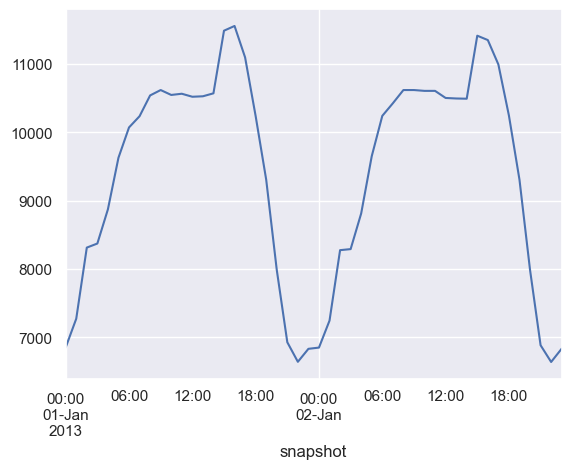

In [26]:
date1 = "2013-01-01"
date2 = "2013-01-02"
n.loads_t.p.loc[date1:date2].sum(axis=1).plot()

Expansion and generation charts

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3549183427.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



<AxesSubplot:xlabel='snapshot'>

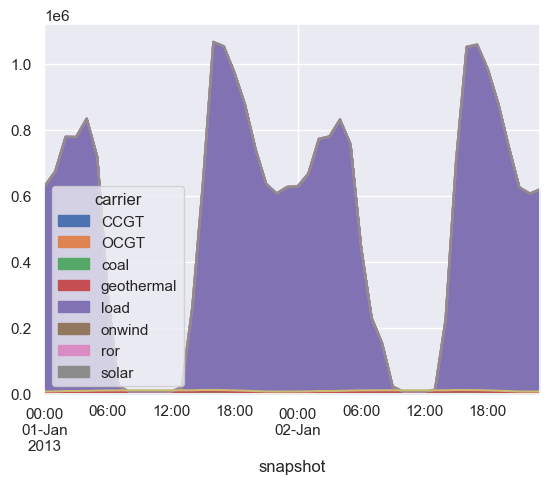

In [27]:
date1 = "2013-01-01"
date2 = "2013-01-02"
n.generators_t.p.loc[date1:date2].groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")

n.loads_t.p.loc[date1:date2].sum(axis=1).plot()

In [28]:
n.generators_t.p_max_pu.loc["2013-01-01 06:00":"2013-01-01 15:00"]   #constraint
n.generators_t.p_max_pu.loc["2013-01-01 06:00":"2013-01-01 15:00"].groupby(n.generators.carrier, axis=1).mean()  #resource availability
n.generators.marginal_cost 

curtailment = n.generators_t.p_max_pu * n.generators.p_nom_opt - n.generators_t.p
curtailment.loc["2013-01-01 06:00":"2013-01-01 15:00"].sum(axis=1)

n.generators_t.p.loc[:, n.generators.carrier == "load"].loc["2013-01-01 06:00":"2013-01-01 15:00"]   #load shedding



n.generators[["p_nom", "p_nom_opt"]]    #status

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\2573341186.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



,p_nom,p_nom_opt
Generator,,
C31,1.020000e+02,5.609529e+02
C32,1.890000e+02,4.902655e+02
C33,1.290000e+02,6.264501e+02
C34,1.500000e+02,6.218910e+02
C35,2.482000e+02,5.500452e+02
...,...,...
80 load,1.000000e+09,1.000000e+09
81 load,1.000000e+09,1.000000e+09
82 load,1.000000e+09,1.000000e+09


In [29]:
expanded_generators = n.generators[n.generators["p_nom_opt"] > n.generators["p_nom"] * 2]
print(expanded_generators[["carrier", "p_nom", "p_nom_opt"]])

          carrier  p_nom   p_nom_opt
Generator                           
C31          CCGT  102.0  560.952922
C32          CCGT  189.0  490.265451
C33          CCGT  129.0  626.450074
C34          CCGT  150.0  621.890958
C35          CCGT  248.2  550.045165
...           ...    ...         ...
74 solar    solar    0.0    0.000039
76 solar    solar    0.0    0.000039
79 solar    solar    0.0    0.000040
82 solar    solar    0.0    0.000039
83 solar    solar    0.0    0.000039

[102 rows x 3 columns]


In [30]:
print(expanded_generators[["carrier", "marginal_cost"]])



          carrier  marginal_cost
Generator                       
C31          CCGT      46.813041
C32          CCGT      46.813913
C33          CCGT      46.812501
C34          CCGT      46.812533
C35          CCGT      46.813154
...           ...            ...
74 solar    solar       0.019012
76 solar    solar       0.019639
79 solar    solar       0.020383
82 solar    solar       0.019386
83 solar    solar       0.020935

[102 rows x 2 columns]


In [31]:
curtailment = n.generators_t.p_max_pu * n.generators.p_nom_opt - n.generators_t.p
print(curtailment.loc[:, expanded_generators.index].sum(axis=1))

snapshot
2013-01-01 00:00:00    0.000020
2013-01-01 01:00:00    0.000018
2013-01-01 02:00:00    0.000019
2013-01-01 03:00:00    0.000019
2013-01-01 04:00:00    0.000021
                         ...   
2013-12-31 19:00:00    0.000073
2013-12-31 20:00:00    0.000058
2013-12-31 21:00:00    0.000044
2013-12-31 22:00:00    0.000036
2013-12-31 23:00:00    0.000028
Length: 8760, dtype: float64


In [32]:
curtailment = n.generators_t.p_max_pu * n.generators.p_nom_opt - n.generators_t.p
curtailment_expanded = curtailment.loc[:, expanded_generators.index]
print(curtailment_expanded.sum(axis=1).describe())  # Summary of curtailment

total_potential_generation = (n.generators_t.p_max_pu * n.generators.p_nom_opt).loc[:, expanded_generators.index].sum(axis=1)
curtailment_percentage = (curtailment_expanded.sum(axis=1) / total_potential_generation) * 100
print(curtailment_percentage)  # Percentage of curtailment

count    8.760000e+03
mean     1.702532e+02
std      2.763783e+02
min      9.789811e-07
25%      7.670724e-05
50%      1.274423e+01
75%      2.161901e+02
max      1.273336e+03
dtype: float64
snapshot
2013-01-01 00:00:00    48.095408
2013-01-01 01:00:00    48.416794
2013-01-01 02:00:00     0.000584
2013-01-01 03:00:00     0.000187
2013-01-01 04:00:00     0.000311
                         ...    
2013-12-31 19:00:00     0.000140
2013-12-31 20:00:00     0.000105
2013-12-31 21:00:00     0.000096
2013-12-31 22:00:00     0.000120
2013-12-31 23:00:00     0.000104
Length: 8760, dtype: float64


In [33]:
demand = n.loads_t.p_set.sum(axis=1)
curtailment_vs_demand = pd.DataFrame({
    "curtailment": curtailment_expanded.sum(axis=1),
    "demand": demand
})
print(curtailment_vs_demand.corr())  # Correlation between curtailment and demand

             curtailment   demand
curtailment      1.00000  0.25279
demand           0.25279  1.00000


In [34]:
high_curtailment_hours = curtailment_expanded.sum(axis=1).nlargest(10)
print(high_curtailment_hours)

snapshot
2013-10-15 11:00:00    1273.335667
2013-10-15 10:00:00    1267.106092
2013-10-16 10:00:00    1255.328605
2013-08-26 09:00:00    1247.996844
2013-08-26 10:00:00    1224.965548
2013-08-25 10:00:00    1224.374144
2013-10-16 09:00:00    1218.177715
2013-08-25 09:00:00    1212.058262
2013-10-15 09:00:00    1208.426215
2013-10-05 09:00:00    1176.696776
dtype: float64


In [35]:
storage_capacities = pd.DataFrame(n.statistics.optimal_capacity())
storage_capacities = storage_capacities.drop(index=['Line','Generator'], level=0)
storage_capacities

,,0
component,carrier,
StorageUnit,Reservoir & Dam,4340.625972


In [36]:
n.statistics()

Optimal Capacity  Installed Capacity  \
Generator   Coal                    6.020860e+02        6.000000e+02   
            Combined-Cycle Gas      5.025265e+03        1.192700e+03   
            Geothermal              9.950000e+02        1.350000e+02   
            Onshore Wind            1.370000e+03        9.110670e-01   
            Open-Cycle Gas          1.850000e+02        1.850000e+02   
            Run of River            6.017862e+02        6.017862e+02   
            Solar                   3.000000e+03        1.447219e+01   
            load                    6.700000e+10        6.700000e+10   
Line        AC                      6.159941e+04        3.477151e+04   
Load        -                       0.000000e+00        0.000000e+00   
StorageUnit Reservoir & Dam         4.340626e+03        4.340626e+03   

                                      Supply    Withdrawal      Dispatch  \
Generator   Coal                5.269048e+06  0.000000e+00  5.269048e+06   
            Combined-Cycle Gas  3.549498e+07  0.000000e+00  3.549498e+07   
            Geothermal          8.707822e+06  0.000000e+00  8.707822e+06   
            Onshore Wind        9.130155e+05  0.000000e+00  9.130155e+05   
            Open-Cycle Gas      4.066085e+05  0.000000e+00  4.066085e+05   
            Run of River        2.920437e+06  0.000000e+00  2.920437e+06   
            Solar               3.118284e+06  0.000000e+00  3.118284e+06   
            load                3.720686e+06  0.000000e+00  3.720686e+06   
Line        AC                  2.596753e+08  2.596753e+08  0.000000e+00   
Load        -                   0.000000e+00  7.885000e+07 -7.885000e+07   
StorageUnit Reservoir & Dam     1.829911e+07  0.000000e+00  1.829911e+07   

                                Transmission  Capacity Factor   Curtailment  \
Generator   Coal                0.000000e+00         0.999009  0.000000e+00   
            Combined-Cycle Gas  0.000000e+00         0.806314  0.000000e+00   
            Geothermal          0.000000e+00         0.999039  0.000000e+00   
            Onshore Wind        0.000000e+00         0.076077  2.341991e+05   
            Open-Cycle Gas      0.000000e+00         0.250900  0.000000e+00   
            Run of River        0.000000e+00         0.553989  6.475558e+04   
            Solar               0.000000e+00         0.118656  1.259542e+06   
            load                0.000000e+00         0.000006  0.000000e+00   
Line        AC                  6.252681e+06         0.481227  0.000000e+00   
Load        -                   0.000000e+00              NaN  0.000000e+00   
StorageUnit Reservoir & Dam     0.000000e+00         0.481253  0.000000e+00   

                                Capital Expenditure  Operational Expenditure  \
Generator   Coal                       2.658205e+08             1.697815e+08   
            Combined-Cycle Gas         6.340972e+08             1.661625e+09   
            Geothermal                 0.000000e+00             8.239555e+04   
            Onshore Wind               1.775253e+08             2.227277e+04   
            Open-Cycle Gas             1.090340e+07             2.630498e+07   
            Run of River               2.465120e+08             3.005263e+04   
            Solar                      1.448679e+08             6.069149e+04   
            load                       0.000000e+00             2.976552e+13   
Line        AC                         3.417679e+08             0.000000e+00   
Load        -                          0.000000e+00             0.000000e+00   
StorageUnit Reservoir & Dam            0.000000e+00             1.777125e+05   

                                     Revenue  Market Value  
Generator   Coal                3.255892e+08  6.179280e+01  
            Combined-Cycle Gas  2.295340e+09  6.466659e+01  
            Geothermal          5.642493e+08  6.479799e+01  
            Onshore Wind        4.558139e+12  4.992400e+06  
            Open-Cycle Gas      4.18352

Dispatch

In [37]:
#energy generated by type of powerplant
production_cap = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()
production_cap.sum()

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\2440099205.py:2: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



carrier
CCGT          3.549498e+07
OCGT          4.066085e+05
coal          5.269048e+06
geothermal    8.707822e+06
load          3.720686e+09
onwind        9.130155e+05
ror           2.920437e+06
solar         3.118284e+06
dtype: float64

In [38]:
#installed capacity p_nom= nominal power (MW) and p_nom_opt= optimized nominal power (MW)

gen_cap = n.generators.groupby(["carrier"]).sum()
sto_cap = n.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])

                   p_nom     p_nom_opt
carrier                               
CCGT        1.192700e+03  5.025265e+03
OCGT        1.850000e+02  1.850000e+02
coal        6.000000e+02  6.020860e+02
geothermal  1.350000e+02  9.950000e+02
load        6.700000e+10  6.700000e+10
onwind      9.110670e-01  1.370000e+03
ror         6.017862e+02  6.017862e+02
solar       1.447219e+01  3.000000e+03

hydro storage : p_nom: 4340.625971594  p_nom_opt: 4340.625971594
Empty DataFrame
Columns: [p_nom, p_nom_opt]
Index: []


C:\Users\hie\AppData\Local\Temp\ipykernel_16388\437100673.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



<AxesSubplot:xlabel='snapshot'>

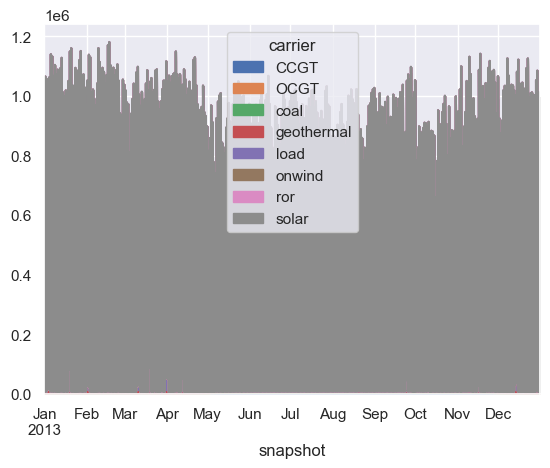

In [39]:
n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3551538610.py:14: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3551538610.py:15: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3551538610.py:16: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3551538610.py:24: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3551538610.py:25: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3551538610.py:34: FutureWarning:

DataFrame.groupby with axis=1 is depre

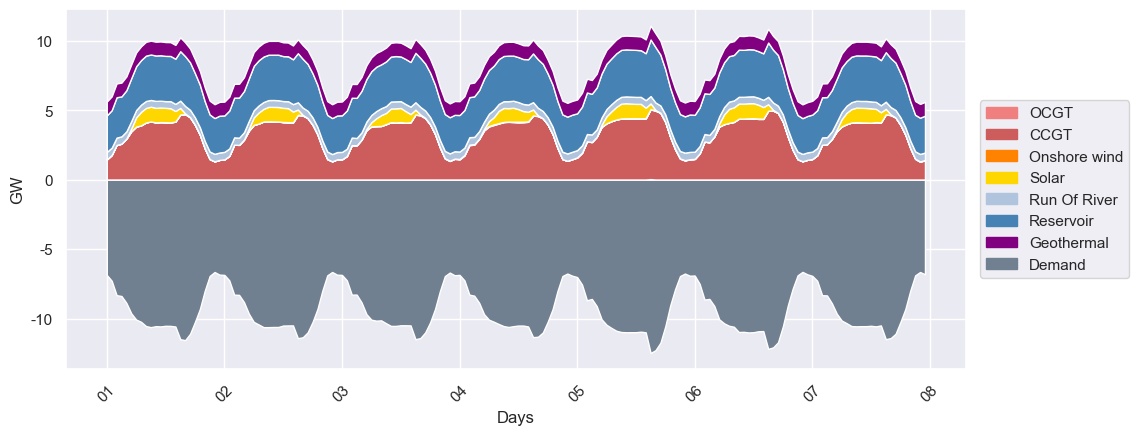

                   p_nom     p_nom_opt
carrier                               
CCGT        1.192700e+03  5.025265e+03
OCGT        1.850000e+02  1.850000e+02
coal        6.000000e+02  6.020860e+02
geothermal  1.350000e+02  9.950000e+02
load        6.700000e+10  6.700000e+10
onwind      9.110670e-01  1.370000e+03
ror         6.017862e+02  6.017862e+02
solar       1.447219e+01  3.000000e+03

hydro storage : p_nom: 4340.625971594  p_nom_opt: 4340.625971594


In [40]:
#production in GW

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates


n = n_solve

first_date = "2013-01-01"
second_date = "2013-01-07"
OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
# oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]

demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1


size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    
# # if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
# #     biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
# else:
#     biomass = np.zeros(size)
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "coal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    coal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["coal"]

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
    
if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)


# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 4))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])





OCGT_color='lightcoral'
CCGT_color='indianred'
Onwind_color='#ff8200'
Solar_color='gold'
ror_color='lightsteelblue'
reservoir_color='steelblue'
coal_color='darkgoldenrod'


demand_color='slategrey'
geothermal_color = 'purple'

A = plt.stackplot(OCGT.index,OCGT,CCGT,Onwind,solar,ror,reservoir,    geothermal,
colors=[OCGT_color,CCGT_color,Onwind_color,Solar_color,ror_color,reservoir_color,geothermal_color], zorder = 3)
plt.stackplot(OCGT.index,demand, colors=[demand_color], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Days')

OCGT_patch = mpatches.Patch(color=OCGT_color, label ='OCGT')
CCGT_patch = mpatches.Patch(color=CCGT_color, label ='CCGT')
wind_patch = mpatches.Patch(color=Onwind_color, label ='Onshore wind')
solar_patch = mpatches.Patch(color=Solar_color, label ='Solar')
ror_patch = mpatches.Patch(color=ror_color, label ='Run Of River')
reservoir_patch = mpatches.Patch(color=reservoir_color, label ='Reservoir')
coal_patch = mpatches.Patch(color=coal_color, label ='Coal')
#oil_patch = mpatches.Patch(color=oil_color, label ='Oil')
#biomass_patch = mpatches.Patch(color=biomass_color, label ='Biomass')
load_patch = mpatches.Patch(color=demand_color, label ='Demand')
geothermal_patch = mpatches.Patch(color=geothermal_color, label ='Geothermal')


handles=[OCGT_patch,CCGT_patch,wind_patch,solar_patch,ror_patch,reservoir_patch,geothermal_patch,load_patch]

ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.19, 0.5))

image_format = 'eps' # e.g .png, .svg, etc.

#fig.savefig('energy_dispatch_run4.eps', format=image_format, dpi=1200)

plt.show()

gen_cap = n.generators.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))

In [41]:
# List of generator carriers
generator_list = ["CCGT", "OCGT", "oil", "biomass", "geothermal", "onwind", "solar", "ror",""]

# Loop through each carrier in the generator list
for carrier in generator_list:
    # Filter generators by carrier and sum their generation
    if carrier in n.generators.carrier.unique():
        generation = n.generators_t.p.loc[:, n.generators[n.generators.carrier == carrier].index].sum().sum()
        print(f"{carrier} generation (MWh) = {round(generation)}")
    else:
        print(f"{carrier} generation (MWh) = 0 (not present in the network)")

# List of storage unit carriers
generator_list2 = ["hydro"]

# Loop through each carrier in the storage unit list
for carrier in generator_list2:
    # Filter storage units by carrier and sum their generation
    if carrier in n.storage_units.carrier.unique():
        generation = n.storage_units_t.p.loc[:, n.storage_units[n.storage_units.carrier == carrier].index].sum().sum()
        print(f"{carrier} generation (MWh) = {round(generation)}")
    else:
        print(f"{carrier} generation (MWh) = 0 (not present in the network)")

CCGT generation (MWh) = 35494985
OCGT generation (MWh) = 406608
oil generation (MWh) = 0 (not present in the network)
biomass generation (MWh) = 0 (not present in the network)
geothermal generation (MWh) = 8707822
onwind generation (MWh) = 913015
solar generation (MWh) = 3118284
ror generation (MWh) = 2920437
 generation (MWh) = 0 (not present in the network)
hydro generation (MWh) = 18299115


C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3008600833.py:7: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3008600833.py:8: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3008600833.py:9: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3008600833.py:15: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3008600833.py:16: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\3008600833.py:25: FutureWarning:

DataFrame.groupby with axis=1 is deprecat

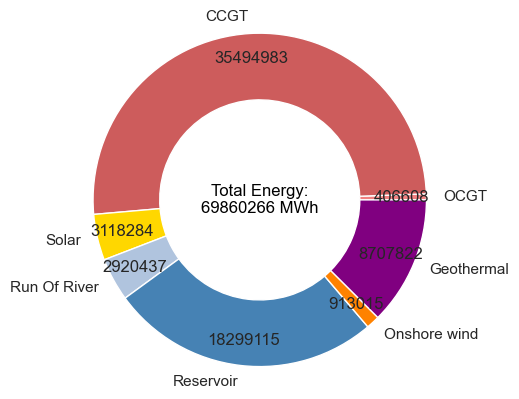

In [42]:
import matplotlib.pyplot as plt
first_date = "2013-01-01"
second_date = "2014-01-01"

time_aggregation = 1   #number hour hours considered by snapshot

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]*time_aggregation
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]*time_aggregation
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]*time_aggregation
#oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]*time_aggregation


size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]*time_aggregation
else:
    ror = np.zeros(size)
    
# if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
#     biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]*time_aggregation
# else:
#     biomass = np.zeros(size)
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]*time_aggregation
else:
    CCGT = np.zeros(size)

# if "H2" in n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
#     H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]*time_aggregation
# else:
#     H2 = np.zeros(size)
    
# if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
#     battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]*time_aggregation
# else:
#     battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)*time_aggregation
else:
    reservoir = np.zeros(size)

if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)


# Original data
labels = ['OCGT', 'CCGT', 'Solar', 'Run Of River', 'Reservoir', 'Onshore wind', 'Geothermal']
sizes = [OCGT.sum(), CCGT.sum(), solar.sum(), ror.sum(), reservoir.sum(),Onwind.sum(),  geothermal.sum()]
colors = [OCGT_color, CCGT_color, Solar_color, ror_color, reservoir_color,Onwind_color,  geothermal_color]

# Filter data based on size > 0.5
filtered_labels = []
filtered_sizes = []
filtered_colors = []

for label, size, color in zip(labels, sizes, colors):
    if size > 10:
        filtered_labels.append(label)
        filtered_sizes.append(size)
        filtered_colors.append(color)

# Calculate the total sum of energy production
total_production = sum(filtered_sizes)

# Function to format the label text with actual values
def format_label(value):
    int_value = int(value)
    return str(int_value)

# Generate the pie chart
plt.pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors, autopct=lambda x: str(int(round(x * total_production / 100))), pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total Energy:\n{int(total_production)} MWh', fontsize=12, color='black', ha='center', va='center')

#plt.savefig('energy_pie_run4.eps', format=image_format, dpi=1200)
plt.show()

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\2084180376.py:3: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



<AxesSubplot:xlabel='snapshot'>

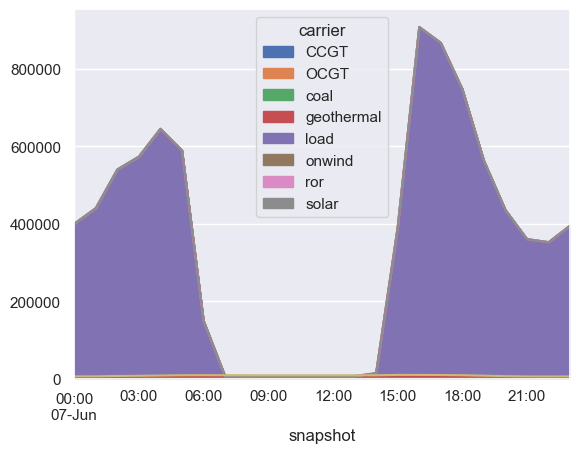

In [43]:
date1 = "2013-06-07"
date2 = "2014-01-01"
n.generators_t.p.loc[date1:date1].groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")
n.loads_t.p.loc[date1:date1].sum(axis=1).plot()

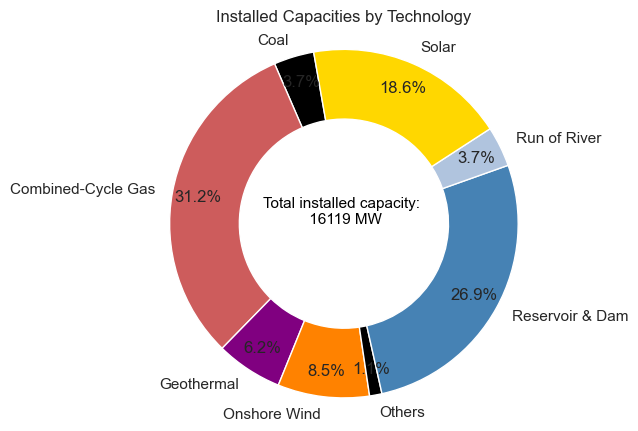

In [44]:
#selecting generation capacities from statistics
capacities = pd.DataFrame(n.statistics.optimal_capacity())
capacities = capacities.drop(index=['Line','Load'], level=0)
capacities = capacities.reset_index(level=0, drop=True)
capacities.rename(columns={0:"MW"}, inplace=True)
capacities.index.name = "Technology"
capacities = capacities.drop(index=['load'])
capacities['Percentage'] = capacities['MW']/capacities['MW'].sum()*100

#defining colors for each technology
H2_color='darkgoldenrod'
battery_color='tan'
demand_color='slategrey'
aggregated_small_capacities = 'black'

for i in range(len(capacities.index)):
    tech = capacities.index[i]  # Access the index value, which is the technology name
    if tech == "Open-Cycle Gas" : capacities.loc[tech, "Color"] = 'lightcoral'
    elif tech == "Combined-Cycle Gas" : capacities.loc[tech, "Color"] = 'indianred'
    elif tech == "Solar" : capacities.loc[tech, "Color"] = 'gold'
    elif tech == "Run of River" : capacities.loc[tech, "Color"] = 'lightsteelblue'
    elif tech == "Onshore Wind" : capacities.loc[tech, "Color"] = '#ff8200'
    elif tech == "Reservoir & Dam" : capacities.loc[tech, "Color"] = 'steelblue'
    elif tech == "Oil" : capacities.loc[tech, "Color"] = 'grey'
    elif tech == "Geothermal" : capacities.loc[tech, "Color"] = 'purple'
    elif tech == "Biomass" : capacities.loc[tech, "Color"] = '#73A917'
    elif tech == "Coal" : capacities.loc[tech, "Color"] = 'black'

# Identify, adding and removing capacities smaller than 1%
small_capacities = capacities[capacities['Percentage'] < 2]
capacities.loc['Others'] = [small_capacities['MW'].sum(), small_capacities['Percentage'].sum(), aggregated_small_capacities]
capacities = capacities.drop(index=small_capacities.index)
capacities = capacities.sort_index()

#plotting the results

plt.figure(figsize=(5, 5))
plt.pie(capacities['MW'], labels=capacities.index, colors=capacities['Color'], autopct='%1.1f%%', startangle=100, pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Calculate total installed capacities
total_capacity = capacities['MW'].sum()

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total installed capacity: \n {int(total_capacity)} MW', fontsize=11, color='black', ha='center')
plt.title('Installed Capacities by Technology')
plt.show()

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\1452680790.py:2: DeprecatedWarning:

dispatch is deprecated as of 0.28 and will be removed in 0.29. Use 'energy_balance' instead.



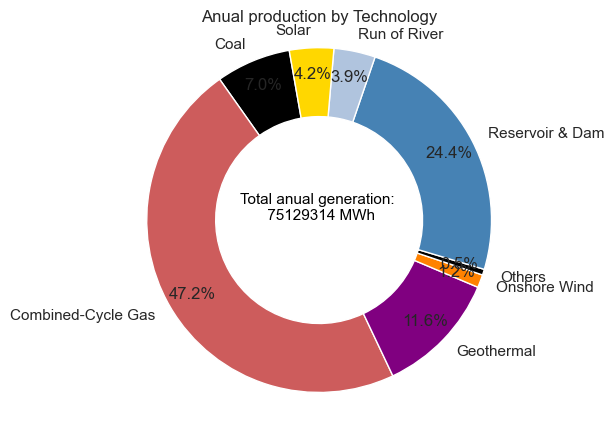

In [45]:
#selecting production from statistics
production = pd.DataFrame(n.statistics.dispatch())
production = production.drop(index=['Line','Load'], level=0)
production = production.reset_index(level=0, drop=True)
production.rename(columns={0:"MWh"}, inplace=True)
production.index.name = "Technology"
production = production.drop(index=['load'])
production['Percentage'] = production['MWh']/production['MWh'].sum()*100

#defining colors for each technology
H2_color='darkgoldenrod'
battery_color='tan'
demand_color='slategrey'
aggregated_small_capacities = 'black'

for i in range(len(production.index)):
    tech = production.index[i]  # Access the index value, which is the technology name
    if tech == "Open-Cycle Gas" : production.loc[tech, "Color"] = 'lightcoral'
    elif tech == "Combined-Cycle Gas" : production.loc[tech, "Color"] = 'indianred'
    elif tech == "Solar" : production.loc[tech, "Color"] = 'gold'
    elif tech == "Run of River" : production.loc[tech, "Color"] = 'lightsteelblue'
    elif tech == "Onshore Wind" : production.loc[tech, "Color"] = '#ff8200'
    elif tech == "Reservoir & Dam" : production.loc[tech, "Color"] = 'steelblue'
    elif tech == "Oil" : production.loc[tech, "Color"] = 'grey'
    elif tech == "Geothermal" : production.loc[tech, "Color"] = 'purple'
    elif tech == "Biomass" : production.loc[tech, "Color"] = '#73A917'
    elif tech == "Coal" : production.loc[tech, "Color"] = 'black'


# Identify, adding and removing capacities smaller than 1%
small_production = production[production['Percentage'] < 1]
production.loc['Others'] = [small_production['MWh'].sum(), small_production['Percentage'].sum(), aggregated_small_capacities]
production = production.drop(index=small_production.index)
production = production.sort_index()

#plotting the results

plt.figure(figsize=(5, 5))
plt.pie(production['MWh'], labels=production.index, colors=production['Color'], autopct='%1.1f%%', startangle=100, pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Calculate total installed capacities
total_production = production['MWh'].sum()

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total anual generation: \n {int(total_production)} MWh', fontsize=11, color='black', ha='center')
plt.title('Anual production by Technology')
plt.show()


C:\Users\hie\AppData\Local\Temp\ipykernel_16388\2174119847.py:13: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\2174119847.py:19: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\2174119847.py:25: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\2174119847.py:26: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\2174119847.py:27: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

C:\Users\hie\AppData\Local\Temp\ipykernel_16388\2174119847.py:31: FutureWarning:

DataFrame.groupby with axis=1 is depre

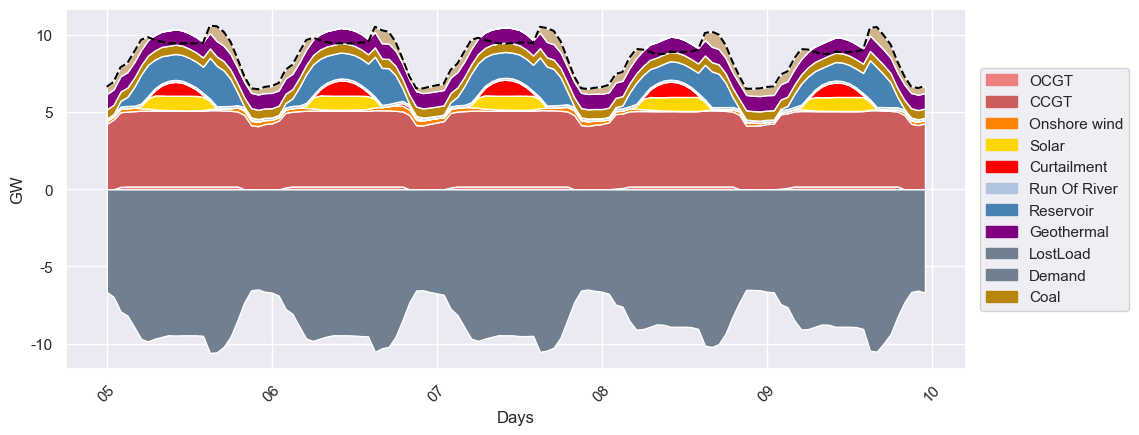

                   p_nom     p_nom_opt
carrier                               
CCGT        1.192700e+03  5.025265e+03
OCGT        1.850000e+02  1.850000e+02
coal        6.000000e+02  6.020860e+02
geothermal  1.350000e+02  9.950000e+02
load        6.700000e+10  6.700000e+10
onwind      9.110670e-01  1.370000e+03
ror         6.017862e+02  6.017862e+02
solar       1.447219e+01  3.000000e+03

hydro storage : p_nom: 4340.625971594  p_nom_opt: 4340.625971594
Empty DataFrame
Columns: [p_nom, p_nom_opt]
Index: []


In [47]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

first_date = "2013-06-05"
second_date = "2013-06-09"

#Hourly solar curtailment calculation
maximum_solar_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='solar') * n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]['p_nom_opt']
maximum_solar_generation = maximum_solar_generation.sum(axis=1)
solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
curtailment_solar = maximum_solar_generation - solar_generation

#Hourly wind curtailment calculation
maximum_wind_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='onwind') * n.generators.loc[[idx for idx in n.generators.index if 'onwind' in idx]]['p_nom_opt']
maximum_wind_generation = maximum_wind_generation.sum(axis=1)
wind_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
curtailment_wind = maximum_wind_generation- wind_generation

curtailment = curtailment_solar.loc[first_date:second_date] + curtailment_wind.loc[first_date:second_date]

#Hourly generation per technology
OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]


#LoadShedding
load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]

#Hourly load/demand 
demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1

size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    

    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "load" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    load = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["load"]/1000
else:
    load = np.zeros(size)

if "coal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    coal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["coal"]

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
    
if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)



# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 4))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])

OCGT_color='lightcoral'
CCGT_color='indianred'
Onwind_color='#ff8200'
Solar_color='gold'
curtailment_color = 'red'
ror_color='lightsteelblue'
reservoir_color='steelblue'
coal_color='darkgoldenrod'

demand_color='slategrey'
geothermal_color = 'purple'
lostload_color = "tan"

A = plt.stackplot(OCGT.index, OCGT, CCGT, Onwind, solar, curtailment, ror,reservoir, coal,  geothermal,load,
colors=[OCGT_color,CCGT_color,Onwind_color,Solar_color,curtailment_color,ror_color,reservoir_color,coal_color,geothermal_color,lostload_color], zorder = 3)
plt.stackplot(OCGT.index,demand, colors=[demand_color], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Days')

OCGT_patch = mpatches.Patch(color=OCGT_color, label ='OCGT')
CCGT_patch = mpatches.Patch(color=CCGT_color, label ='CCGT')
wind_patch = mpatches.Patch(color=Onwind_color, label ='Onshore wind')
solar_patch = mpatches.Patch(color=Solar_color, label ='Solar')
curtailment_patch = mpatches.Patch(color=curtailment_color, label = 'Curtailment')
ror_patch = mpatches.Patch(color=ror_color, label ='Run Of River')
reservoir_patch = mpatches.Patch(color=reservoir_color, label ='Reservoir')

load_patch = mpatches.Patch(color=demand_color, label ='Demand')
geothermal_patch = mpatches.Patch(color=geothermal_color, label ='Geothermal')
lostload_patch = mpatches.Patch(color=demand_color, label ='LostLoad')
coal_patch = mpatches.Patch(color=coal_color, label ='Coal')

handles=[OCGT_patch,CCGT_patch,wind_patch,solar_patch,curtailment_patch,ror_patch,reservoir_patch,geothermal_patch,lostload_patch,load_patch,coal_patch]

ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.19, 0.5))

image_format = 'eps' # e.g .png, .svg, etc.

demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)

# Plot the demand as a time series
plt.plot(demand.abs(), color="black", label="abs(withdrawal)", linestyle="dashed", zorder=100)
#fig.savefig(r'C:\Users\Carlos\Desktop\satand_alone_transition.eps', format=image_format, dpi=1200)

plt.show()

gen_cap = n.generators.groupby(["carrier"]).sum()
sto_cap = n.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])

Lost load

In [ ]:
demand = n.loads_t.p_set.loc["2013"].sum(axis=1)
demand.idxmax()
demand.sum()

78849999.99998802

In [ ]:
load_shedding = n.generators_t.p.loc["2013"].groupby(n.generators.carrier, axis=1).sum()["load"]
round(load_shedding.sum())

C:\Users\hie\AppData\Local\Temp\ipykernel_22624\1555212878.py:1: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



3720685831

In [ ]:
#LL or Loadshedding is in kW/kWh 
lostload = n.generators_t.p.filter(like= "load")
#lostload.idxmax()
peakLL = pd.DataFrame(index = lostload.index)
peakLL["Peak LL"] = lostload.max(axis=1)/1000
sortedLL = peakLL.sort_values("Peak LL", ascending=False)
LL_contribution = sortedLL.iloc[0:9]
LL_contribution.mean()

Peak LL    622.391584
dtype: float64